<a href="https://colab.research.google.com/github/tarumi283/tarumi/blob/main/qPCR_%E6%A4%9C%E9%87%8F%E7%B7%9A%EF%BC%BF%E6%BF%83%E5%BA%A6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

qPCR Normalized Results:
  Sample      Group  Target_Ct  Housekeeping_Ct  Target_RelConc  \
0     C1    Control      22.63            25.19        0.088411   
1     C2    Control      21.25            25.67        0.178726   
2     C3    Control      20.41            25.44        0.274318   
3     C4    Control      19.57            26.79        0.421038   
4     S1  Treatment      20.95            24.61        0.208276   
5     S2  Treatment      19.65            24.40        0.404204   
6     S3  Treatment      19.81            24.69        0.372529   
7     S4  Treatment      20.29            25.06        0.291632   
8     S5  Treatment      19.50            24.67        0.436342   

   Housekeeping_RelConc  Normalized_Conc  Relative_Expression  
0              1.327339         0.066608             0.179902  
1              0.946538         0.188821             0.509990  
2              1.113014         0.246464             0.665681  
3              0.430033         0.979083        

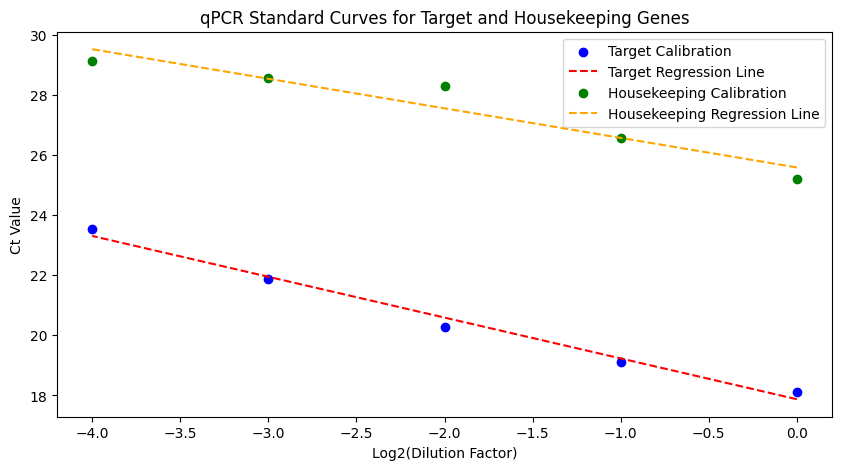

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import linregress

# --- ターゲット遺伝子の希釈系列 ---
target_dilution_series = {
    "Dilution": [1, 1/2, 1/4, 1/8, 1/16],  # 希釈倍率（基準：1X）
    "Ct": [18.12, 19.13, 20.29, 21.88, 23.54]  # ターゲット遺伝子のCt値
}

# --- 内部標準遺伝子の希釈系列 ---
housekeeping_dilution_series = {
    "Dilution": [1, 1/2, 1/4, 1/8, 1/16],   # 希釈倍率（基準：1X）
    "Ct": [25.21, 26.57, 28.32, 28.57, 29.13]  # 内部標準遺伝子のCt値
}

# DataFrameに変換
target_df = pd.DataFrame(target_dilution_series)
housekeeping_df = pd.DataFrame(housekeeping_dilution_series)

# 希釈倍率を log2 変換（回帰用に使用）
target_df["Log2_Dilution"] = np.log2(target_df["Dilution"])
housekeeping_df["Log2_Dilution"] = np.log2(housekeeping_df["Dilution"])

# Ct値と log2(希釈倍率) の関係で線形回帰
# 今回は、Ct値 = slope * Log2(Dilution) + intercept として回帰します。
target_slope, target_intercept, _, _, _ = linregress(target_df["Log2_Dilution"], target_df["Ct"])
housekeeping_slope, housekeeping_intercept, _, _, _ = linregress(housekeeping_df["Log2_Dilution"], housekeeping_df["Ct"])

# 回帰式を用いて Ct値 → 相対濃度（希釈倍率）に変換する関数
def ct_to_relative_concentration(ct, slope, intercept):
    # Ct = slope * log2(Dilution) + intercept から
    # log2(Dilution) = (Ct - intercept) / slope となるので
    log2_dilution = (ct - intercept) / slope
    return 2 ** log2_dilution

# --- サンプルのCtデータ ---
# サンプルデータに「Group」列（Control群とTreatment群）を追加
sample_data = {
    "Sample": ["C1", "C2", "C3", "C4", "S1", "S2", "S3", "S4", "S5"],
    "Group":  ["Control", "Control", "Control", "Control", "Treatment", "Treatment", "Treatment", "Treatment", "Treatment"],
    "Target_Ct": [22.63, 21.25, 20.41, 19.57, 20.95, 19.65, 19.81, 20.29, 19.5],    # ターゲット遺伝子のCt
    "Housekeeping_Ct": [25.19, 25.67, 25.44, 26.79, 24.61, 24.4, 24.69, 25.06, 24.67]  # 内部標準遺伝子のCt
}

# サンプルデータフレームの作成
sample_df = pd.DataFrame(sample_data)

# 各サンプルについて、ターゲットおよび内部標準の相対濃度（希釈倍率）を算出
sample_df["Target_RelConc"] = sample_df["Target_Ct"].apply(lambda x: ct_to_relative_concentration(x, target_slope, target_intercept))
sample_df["Housekeeping_RelConc"] = sample_df["Housekeeping_Ct"].apply(lambda x: ct_to_relative_concentration(x, housekeeping_slope, housekeeping_intercept))

# 内部標準で正規化（ターゲットの相対濃度 ÷ 内部標準の相対濃度）
sample_df["Normalized_Conc"] = sample_df["Target_RelConc"] / sample_df["Housekeeping_RelConc"]

# Control群のNormalized_Concの平均値を算出し、これを基準値とする
control_mean = sample_df[sample_df["Group"] == "Control"]["Normalized_Conc"].mean()

# 各サンプルのNormalized_Concをcontrol_meanで割って Relative Expression を算出
sample_df["Relative_Expression"] = sample_df["Normalized_Conc"] / control_mean

# 結果の表示
print("qPCR Normalized Results:")
print(sample_df)

# CSVファイルとして出力（インデックスは不要）
output_filename = "qPCR_normalized_results.csv"
sample_df.to_csv(output_filename, index=False)
print(f"結果はCSVファイル '{output_filename}' に出力されました。")

# --- 検量線の可視化 ---
plt.figure(figsize=(10, 5))

# ターゲット遺伝子の検量線プロット（横軸: Log2(Dilution), 縦軸: Ct）
plt.scatter(target_df["Log2_Dilution"], target_df["Ct"], label="Target Calibration", color="blue")
plt.plot(target_df["Log2_Dilution"], target_slope * target_df["Log2_Dilution"] + target_intercept,
         linestyle="--", color="red", label="Target Regression Line")

# 内部標準遺伝子の検量線プロット
plt.scatter(housekeeping_df["Log2_Dilution"], housekeeping_df["Ct"], label="Housekeeping Calibration", color="green")
plt.plot(housekeeping_df["Log2_Dilution"], housekeeping_slope * housekeeping_df["Log2_Dilution"] + housekeeping_intercept,
         linestyle="--", color="orange", label="Housekeeping Regression Line")

plt.xlabel("Log2(Dilution Factor)")
plt.ylabel("Ct Value")
plt.title("qPCR Standard Curves for Target and Housekeeping Genes")
plt.legend()
plt.show()